Selecting best features to train model

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import RFECV
import optuna
from optuna.samplers import TPESampler

# Load the CSV file into a pandas DataFrame
file_path = "/Users/rorycave/Metadata.csv"  # Replace with the actual file path
df = pd.read_csv(file_path, delimiter=',')

# Check if DataFrame is empty
if df.empty:
    raise ValueError("The DataFrame is empty. Please check the file path and ensure the CSV is not empty.")

# Specify categorical columns for one-hot encoding
columns_to_encode = ['GPSC']

# Apply one-hot encoding to the specified columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

# Drop columns that are not needed for analysis
columns_to_drop = ['id', 'ST', 'cohort', 'Serotype']
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Drop rows with missing values
df_encoded = df_encoded.dropna()

# Separate features (X) and target variable (y)
X = df_encoded.drop(['Less_than_saturation_point'], axis=1)  # Assuming 'Less_than_3' is the target variable
y = df_encoded['Less_than_saturation_point']

# Ensure the data is not empty
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("Input data is empty. Please check your data loading step.")

# Randomly split dataset into test and train sets
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 4, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 32, 35),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    clf = RandomForestClassifier(**param)
    
    # Using RFECV for feature selection
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), scoring='roc_auc')
    rfecv.fit(X_train, y_train)
    
    # Get the cross-validation score
    score = np.mean(rfecv.cv_results_['mean_test_score'])
    
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the best model with the best hyperparameters
best_model = RandomForestClassifier(**best_params)

# Using RFECV with the best model for feature selection
rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), scoring='roc_auc')
rfecv.fit(X_train, y_train)

# Transform the datasets to the selected features
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

# Train the model with the reduced feature set
best_model.fit(X_train_rfecv, y_train)

# Use the best model for predictions
predict_train = best_model.predict(X_train_rfecv)
predict_test = best_model.predict(X_test_rfecv)

# Extract probabilities for the positive class (assuming binary classification)
probab_train = best_model.predict_proba(X_train_rfecv)[:, 1]
probab_test = best_model.predict_proba(X_test_rfecv)[:, 1]

# Calculate metrics for training data
train_auc = roc_auc_score(y_train, probab_train)
train_report = classification_report(y_train, predict_train)
print("Training AUC:", train_auc)
print("Training Classification Report:\n", train_report)

# Calculate metrics for test data
test_auc = roc_auc_score(y_test, probab_test)
test_report = classification_report(y_test, predict_test)
print("Test AUC:", test_auc)
print("Test Classification Report:\n", test_report)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:", selected_features)

# Get feature importances
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:\n", feature_importance_df)


[I 2024-10-08 07:50:51,452] A new study created in memory with name: no-name-535eac8b-a837-4968-af77-fa034710bc87
[I 2024-10-08 07:54:36,899] Trial 0 finished with value: 0.6556143308643837 and parameters: {'n_estimators': 687, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 34, 'max_features': 'sqrt', 'class_weight': 'balanced', 'bootstrap': False}. Best is trial 0 with value: 0.6556143308643837.
[I 2024-10-08 07:59:08,666] Trial 1 finished with value: 0.65816753642189 and parameters: {'n_estimators': 917, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 32, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': False}. Best is trial 1 with value: 0.65816753642189.
[I 2024-10-08 08:07:02,887] Trial 2 finished with value: 0.6366923449925965 and parameters: {'n_estimators': 728, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'bootstrap': True}. Best is trial 1 with value: 0.6581675364

Best Parameters: {'n_estimators': 917, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 32, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': False}
Training AUC: 0.7257151499438251
Training Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.55      0.62       684
           1       0.59      0.74      0.66       609

    accuracy                           0.64      1293
   macro avg       0.65      0.65      0.64      1293
weighted avg       0.65      0.64      0.64      1293

Test AUC: 0.6953794369645043
Test Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62       172
           1       0.58      0.68      0.63       152

    accuracy                           0.62       324
   macro avg       0.63      0.63      0.62       324
weighted avg       0.63      0.62      0.62       324

Selected Features: Index(['Vaccinetyp

Training model on features best to inlclude

In [21]:


# Load the CSV file into a pandas DataFrame
file_path = "/Users/rorycave/Metadata.csv"  # Replace with the actual file path
df = pd.read_csv(file_path, delimiter=',')

# Check if DataFrame is empty
if df.empty:
    raise ValueError("The DataFrame is empty. Please check the file path and ensure the CSV is not empty.")

# Specify categorical columns for one-hot encoding
columns_to_encode = ['GPSC', 'Serotype']

# Apply one-hot encoding to the specified columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

print(df_encoded.columns)

# Drop columns that are not needed for analysis
columns_to_select = ['Less_than_saturation_point','Vaccinetype', 'Penicillin MIC (μg/mL)', 'Year', 'Age',
       'Population density (km²)', 'Crowd index', 'Social economic score',
       'Number of children age  5 or under in a household',
       'Number of children age  5 to 15  in a household',
       'Number of adults in a household',
       'Erythromycin and Tetracycline', 'GPSC_102',
       'GPSC_14', 'GPSC_163',
       'GPSC_21', 'GPSC_5', 'GPSC_65', 'GPSC_904;9',
       ]

# Select only the relevant columns
df_selected = df_encoded[columns_to_select]

# Separate features and target variable
X = df_selected.drop('Less_than_saturation_point', axis=1)  # Replace 'Vaccinetype' with your actual target variable
y = df_selected['Less_than_saturation_point']  # Replace 'Vaccinetype' with your actual target variable

# Check shapes and contents
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Ensure the data is not empty
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("Input data is empty. Please check your data loading step.")

# Randomly split dataset into test and train sets
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 4, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 32, 35),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    clf = RandomForestClassifier(**param, random_state=RANDOM_SEED)
    
    # Cross-validation on the reduced feature set
    scores = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED), scoring='roc_auc')
    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the best model with the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=RANDOM_SEED)
best_model.fit(X_train, y_train)

# Use the best model for predictions
predict_train = best_model.predict(X_train)
predict_test = best_model.predict(X_test)

# Extract probabilities for the positive class (assuming binary classification)
probab_train = best_model.predict_proba(X_train)[:, 1]
probab_test = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics for training data
train_auc = roc_auc_score(y_train, probab_train)
train_report = classification_report(y_train, predict_train)
print("Training AUC:", train_auc)
print("Training Classification Report:\n", train_report)

# Calculate metrics for test data
test_auc = roc_auc_score(y_test, probab_test)
test_report = classification_report(y_test, predict_test)
print("Test AUC:", test_auc)
print("Test Classification Report:\n", test_report)

# Get feature importances
feature_importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:\n", feature_importance_df)

[I 2024-10-08 09:28:26,067] A new study created in memory with name: no-name-d849e39b-1b29-4397-8335-b00150922952


Index(['id', 'Less_than_saturation_point', 'ST', 'Vaccinetype',
       'Penicillin MIC (μg/mL)', 'Year', 'Age', 'Population density (km²)',
       'Crowd index', 'Social economic score',
       'Number of children age  5 or under in a household',
       'Number of children age  5 to 15  in a household',
       'Number of adults in a household', 'cohort', 'Erythromycin',
       'Tetracycline', 'Erythromycin and Tetracycline', 'GPSC_10', 'GPSC_102',
       'GPSC_104', 'GPSC_116', 'GPSC_13', 'GPSC_14', 'GPSC_145',
       'GPSC_148;903', 'GPSC_163', 'GPSC_17', 'GPSC_184', 'GPSC_201',
       'GPSC_21', 'GPSC_211', 'GPSC_217', 'GPSC_228', 'GPSC_30', 'GPSC_33',
       'GPSC_34', 'GPSC_38', 'GPSC_40', 'GPSC_43', 'GPSC_455', 'GPSC_5',
       'GPSC_54', 'GPSC_60', 'GPSC_65', 'GPSC_71', 'GPSC_880;22;857;882',
       'GPSC_904;9', 'GPSC_92', 'Serotype_10A', 'Serotype_10B', 'Serotype_11A',
       'Serotype_13', 'Serotype_14', 'Serotype_15A', 'Serotype_15B/C',
       'Serotype_16F', 'Serotype_17F', 

[I 2024-10-08 09:28:30,001] Trial 0 finished with value: 0.6641194515597094 and parameters: {'n_estimators': 687, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 34, 'max_features': 'sqrt', 'class_weight': 'balanced', 'bootstrap': False}. Best is trial 0 with value: 0.6641194515597094.
[I 2024-10-08 09:28:35,128] Trial 1 finished with value: 0.6645295559444431 and parameters: {'n_estimators': 917, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 32, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': False}. Best is trial 1 with value: 0.6645295559444431.
[I 2024-10-08 09:28:42,080] Trial 2 finished with value: 0.6414776381212505 and parameters: {'n_estimators': 728, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'bootstrap': True}. Best is trial 1 with value: 0.6645295559444431.
[I 2024-10-08 09:28:45,890] Trial 3 finished with value: 0.6639033099328 and parameters: {'n_estimator

Best Parameters: {'n_estimators': 917, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 32, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': False}
Training AUC: 0.7235065633432238
Training Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.55      0.61       684
           1       0.59      0.74      0.66       609

    accuracy                           0.64      1293
   macro avg       0.65      0.64      0.64      1293
weighted avg       0.65      0.64      0.63      1293

Test AUC: 0.6951499388004896
Test Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.55      0.61       172
           1       0.58      0.69      0.63       152

    accuracy                           0.62       324
   macro avg       0.62      0.62      0.62       324
weighted avg       0.63      0.62      0.62       324

Feature Importances:
                

plot roc-curve

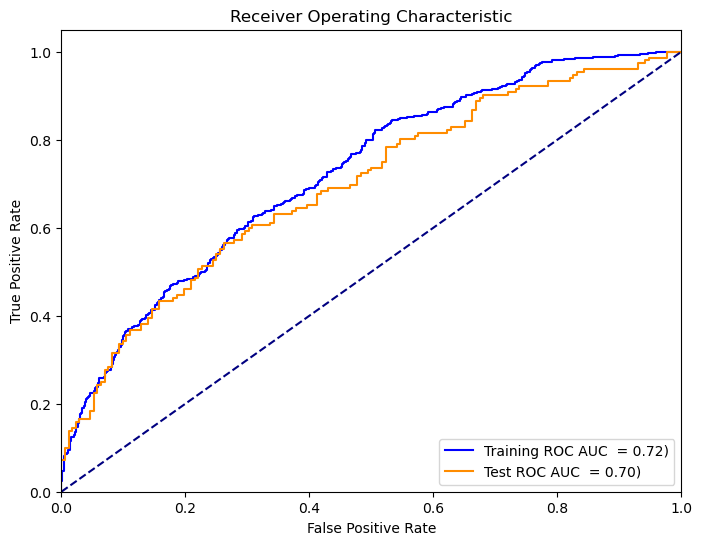

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


#Compute ROC curve and ROC area for training data
fpr_train, tpr_train, _ = roc_curve(y_train, probab_train)
fpr_test, tpr_test, _ = roc_curve(y_test, probab_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='Training ROC AUC  = %0.2f)' % train_auc)
plt.plot(fpr_test, tpr_test, color='darkorange', label='Test ROC AUC  = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the plot as an SVG file
plt.savefig('roc_curve_combined.svg')

# Show the plot
plt.show()

plot precision_recall_curve

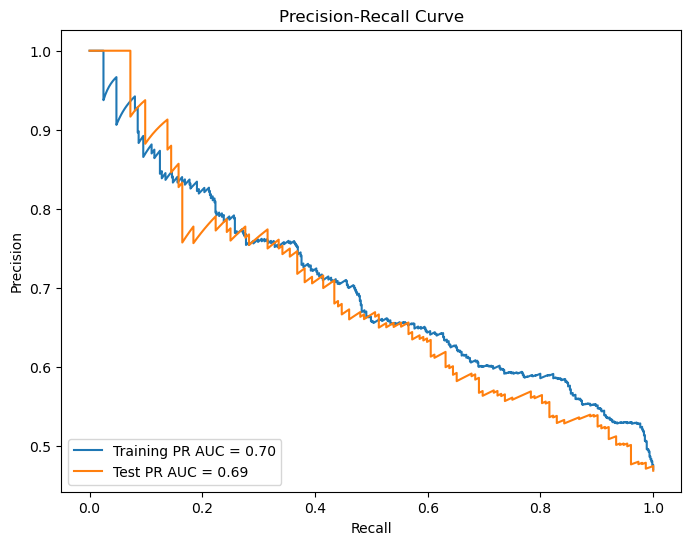

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall and PR AUC for training data
precision_train, recall_train, _ = precision_recall_curve(y_train, probab_train)
pr_auc_train = average_precision_score(y_train, probab_train)

# Compute Precision-Recall and PR AUC for test data
precision_test, recall_test, _ = precision_recall_curve(y_test, probab_test)
pr_auc_test = average_precision_score(y_test, probab_test)

# Plotting the Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Training PR AUC = {pr_auc_train:.2f}')
plt.plot(recall_test, precision_test, label=f'Test PR AUC = {pr_auc_test:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Save the plot as an SVG file
plt.savefig('precision_recall_curve_combined.svg')

# Show the plot
plt.show()


Compute Test Precision-Recall 

In [26]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import numpy as np

# Function to calculate confidence intervals using bootstrapping
def bootstrap_auc(model, X_test, y_test, n_iterations=1000, alpha=0.95):
    aucs = []
    
    for i in range(n_iterations):
        # Resample the test set
        X_resampled, y_resampled = resample(X_test, y_test)
        
        # Get predicted probabilities for the positive class
        probab_test_resampled = model.predict_proba(X_resampled)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_resampled, probab_test_resampled)
        aucs.append(auc)
    
    # Convert list to numpy array for easier calculations
    aucs = np.array(aucs)
    
    # Compute the confidence interval
    lower = np.percentile(aucs, (1.0 - alpha) / 2.0 * 100)
    upper = np.percentile(aucs, (alpha + (1.0 - alpha) / 2.0) * 100)
    
    return lower, upper

# Assuming best_model, X_test, y_test, and test_auc are defined earlier in your script
lower_ci, upper_ci = bootstrap_auc(best_model, X_test, y_test, n_iterations=1000)

print(f"Test AUC: {test_auc:.3f}")
print(f"95% Confidence Interval for Test AUC: [{lower_ci:.3f}, {upper_ci:.3f}]")


Test AUC: 0.695
95% Confidence Interval for Test AUC: [0.637, 0.755]


Sensitivity Specificity and their CI

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import numpy as np

# Function to calculate Sensitivity, Specificity, and G-mean
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn)  # Sensitivity or Recall
    specificity = tn / (tn + fp)  # Specificity
    g_mean = np.sqrt(sensitivity * specificity)  # G-mean
    
    return sensitivity, specificity, g_mean

# Function to calculate confidence intervals for Sensitivity, Specificity, and G-mean using bootstrapping
def bootstrap_metrics(model, X_test, y_test, n_iterations=1000, alpha=0.95):
    sensitivities = []
    specificities = []
    g_means = []
    
    for i in range(n_iterations):
        # Resample the test set
        X_resampled, y_resampled = resample(X_test, y_test)
        
        # Get predictions for the resampled test set
        y_pred_resampled = model.predict(X_resampled)
        
        # Calculate Sensitivity, Specificity, and G-mean
        sensitivity, specificity, g_mean = calculate_metrics(y_resampled, y_pred_resampled)
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        g_means.append(g_mean)
    
    # Convert lists to numpy arrays
    sensitivities = np.array(sensitivities)
    specificities = np.array(specificities)
    g_means = np.array(g_means)
    
    # Compute confidence intervals
    sensitivity_ci = np.percentile(sensitivities, [(1.0 - alpha) / 2.0 * 100, (alpha + (1.0 - alpha) / 2.0) * 100])
    specificity_ci = np.percentile(specificities, [(1.0 - alpha) / 2.0 * 100, (alpha + (1.0 - alpha) / 2.0) * 100])
    g_mean_ci = np.percentile(g_means, [(1.0 - alpha) / 2.0 * 100, (alpha + (1.0 - alpha) / 2.0) * 100])
    
    return sensitivity_ci, specificity_ci, g_mean_ci

# Calculate Sensitivity, Specificity, and G-mean on the original test set
y_pred_test = best_model.predict(X_test)
sensitivity, specificity, g_mean = calculate_metrics(y_test, y_pred_test)

# Calculate confidence intervals for Sensitivity, Specificity, and G-mean
sensitivity_ci, specificity_ci, g_mean_ci = bootstrap_metrics(best_model, X_test, y_test, n_iterations=1000)

print(f"Sensitivity: {sensitivity:.3f}")
print(f"95% Confidence Interval for Sensitivity: [{sensitivity_ci[0]:.3f}, {sensitivity_ci[1]:.3f}]")

print(f"Specificity: {specificity:.3f}")
print(f"95% Confidence Interval for Specificity: [{specificity_ci[0]:.3f}, {specificity_ci[1]:.3f}]")

print(f"G-mean: {g_mean:.3f}")
print(f"95% Confidence Interval for G-mean: [{g_mean_ci[0]:.3f}, {g_mean_ci[1]:.3f}]")

Sensitivity: 0.691
95% Confidence Interval for Sensitivity: [0.612, 0.761]
Specificity: 0.552
95% Confidence Interval for Specificity: [0.477, 0.626]
G-mean: 0.618
95% Confidence Interval for G-mean: [0.565, 0.666]


In [ ]:
Shap plots

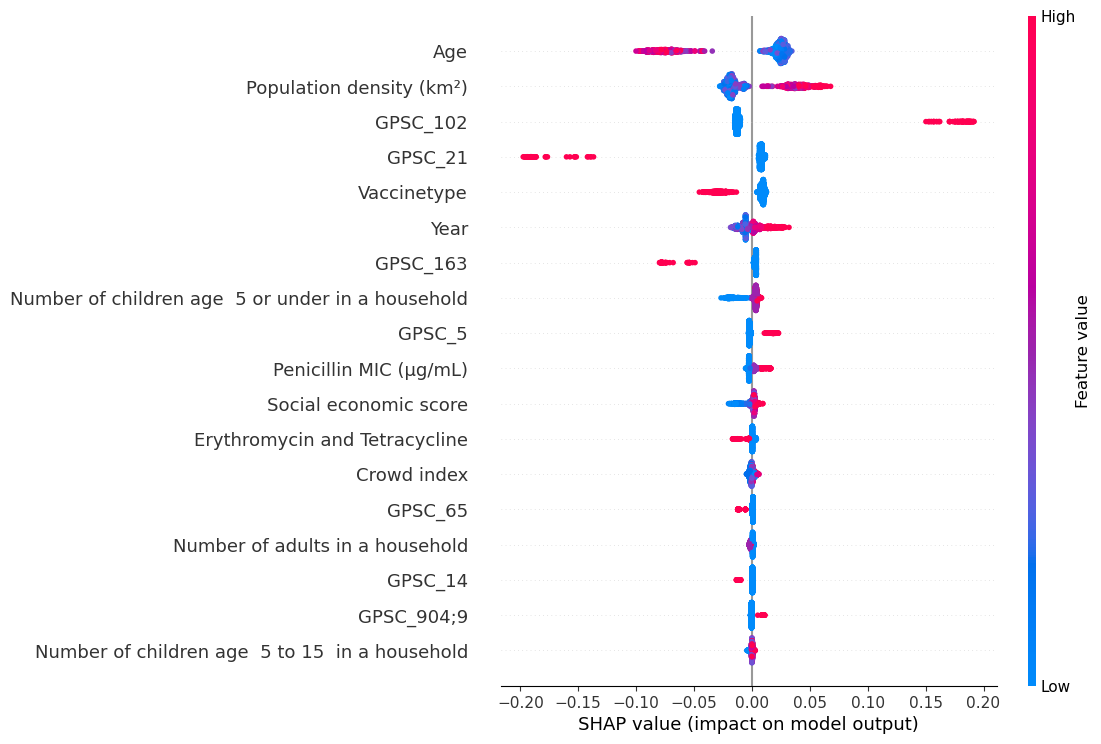

In [28]:
import shap

# Create a SHAP explainer object
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Select the class index you are interested in (e.g., class 0)
class_index = 1

# Extract SHAP values for the selected class
shap_values_class = shap_values[:, :, class_index]

# Extract expected value for the selected class
expected_value_class = explainer.expected_value[class_index]

# Create an Explanation object for the selected class
explanation = shap.Explanation(
    values=shap_values_class,
    base_values=expected_value_class,
    data=X
)

shap.plots.beeswarm(explanation, max_display=21, show=False)
plt.savefig("beeswarm_plot.svg", format='svg')


In [ ]:
plot partial plot

LOWESS Trend for Age
LOWESS Trend for Population density (km²)
LOWESS Trend for Social economic score
LOWESS Trend for Year
LOWESS Trend for Number of children age  5 or under in a household
LOWESS Trend for Number of adults in a household
LOWESS Trend for Number of children age  5 to 15  in a household
LOWESS Trend for Penicillin MIC (μg/mL)


/Users/rorycave/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


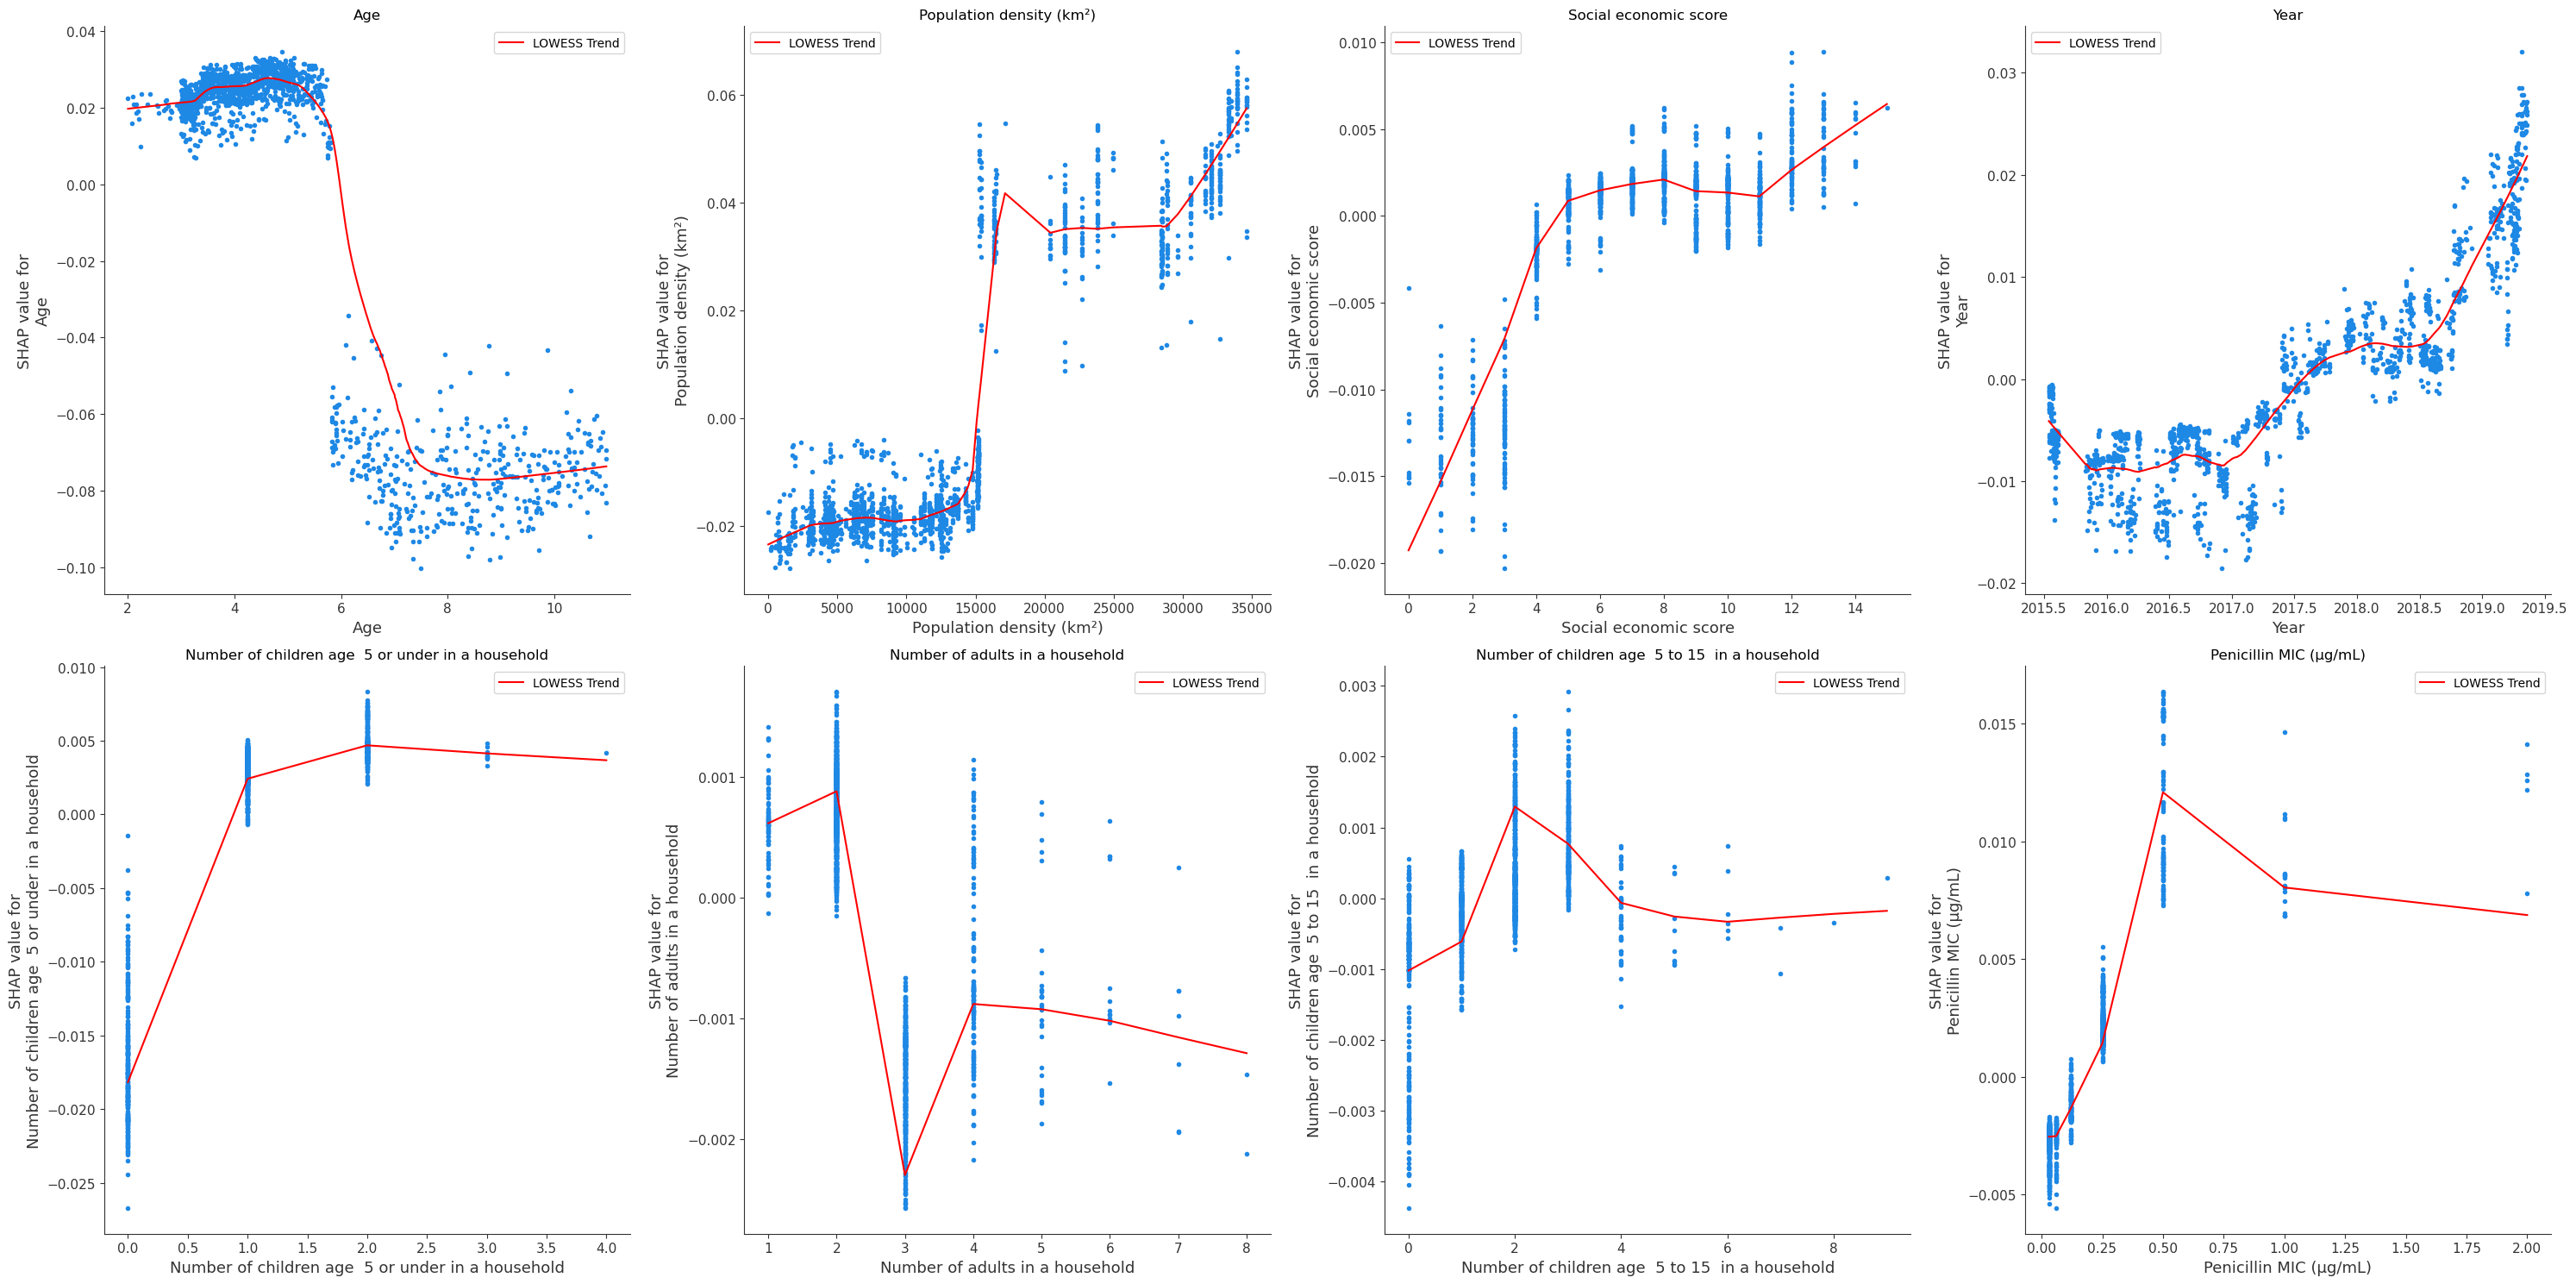

LOWESS Trend for Age
LOWESS Trend for Population density (km²)
LOWESS Trend for Social economic score
LOWESS Trend for Year
LOWESS Trend for Number of children age  5 or under in a household
LOWESS Trend for Number of adults in a household
LOWESS Trend for Number of children age  5 to 15  in a household
LOWESS Trend for Penicillin MIC (μg/mL)


In [29]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap

# Define the features you want to plot and their corresponding filenames
features = [
    ("Age", "pp_Age_plot.svg"),
    ("Population density (km²)", "Population_density.svg"),
    ("Social economic score", "pp_Ses_score.svg"),
    ("Year", "yeare.svg"),
    ("Number of children age  5 or under in a household", "number5.svg"),
    ("Number of adults in a household", "adults.svg"),
    ("Number of children age  5 to 15  in a household", "5_15.svg"),
    ("Penicillin MIC (μg/mL)", "Penicillin.svg"),
]

shap_values_sliced = shap_values[:, :, 1]  # Select the first interaction effect

# Create a single figure for all plots
n_features = len(features)
nrows = 2  # Set the number of rows to 2
ncols = 4  # Set the number of columns to 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 15))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Function to analyze and print trends
def analyze_trend(feature_name, shap_values, feature_data, ax):
    # Generate dependence plot
    shap.dependence_plot(feature_name, shap_values, feature_data, interaction_index=None, show=False, ax=ax)
    
    # Extract data from plot for trend analysis
    feature_values = feature_data[feature_name].values
    shap_values_feature = shap_values[:, feature_data.columns.get_loc(feature_name)]
    
    # Perform LOWESS smoothing to find the trend
    lowess = sm.nonparametric.lowess(shap_values_feature, feature_values, frac=0.2)
    
    # Display trend information
    trend_description = f"LOWESS Trend for {feature_name}"
    print(trend_description)
    
    # Plot the LOWESS trend line
    ax.plot(lowess[:, 0], lowess[:, 1], 'r', label='LOWESS Trend')
    ax.legend()

# Iterate over each feature and plot
for i, (feature_name, filename) in enumerate(features):
    analyze_trend(feature_name, shap_values_sliced, X, axes[i])
    
    # Set subplot title (optional)
    axes[i].set_title(feature_name)
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()

# Save the figure
plt.savefig('dependency_plots_combined_with_trends.svg', format='svg')

# Display the plot
plt.show()
()

# Iterate over each feature and plot
for i, (feature_name, filename) in enumerate(features):
    analyze_trend(feature_name, shap_values_sliced, X, axes[i])
    
    # Set subplot title (optional)
    axes[i].set_title(feature_name)
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
# Display the plot
plt.show()